<a href="https://colab.research.google.com/github/AsmatZahra/Unet-with-Monuseg-dataset/blob/master/Unet_with_MonuSeg_Dataset_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/acv assignments/assignment 3/

/content/drive/My Drive/Colab Notebooks/acv assignments/assignment 3


In [0]:
!ls

In [7]:
#Required imports
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

try:
  %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Unknown TensorFlow version: only exists in Colab.
Currently selected TF version: 2.x
Available versions:
 * 1.x
 * 2.x
TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
#from keras import backend as K
#K.set_image_data_format('channels_first')
#K.set_image_data_format('channels_last')

In [0]:
# Set some parameters
im_width = 1000
im_height = 1000
border = 5
path_train_images= "MyMonuSeg/Training/TissueImages/"
path_train_groundtruth= "MyMonuSeg/Training/GroundTruths/"
Npath_train_images= "yMonuSeg/Training/TissueImages/"
Npath_train_groundtruth= "yMonuSeg/Training/GroundTruths/"

In [0]:
# Settin path to dataset
ids = next(os.walk(path_train_images))[2] # list of names all images in the given path
ids_groundTruth= next(os.walk(path_train_groundtruth))[2]
print("No. of images = ", len(ids))
print("No. of images_GroundTruth = ", len(ids_groundTruth))
#print(ids)
#print(ids_groundTruth)

No. of images =  30
No. of images_GroundTruth =  30


In [0]:
#X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
#y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

X = np.zeros((im_height, im_width, len(ids), 1), dtype=np.float32)
y = np.zeros((im_height, im_width, len(ids), 1), dtype=np.float32)

print ("Shape of X is:",X.shape)
print ("Shape of y is:", y.shape)

In [0]:
#Run Once only to convert into .jpg format
'''from glob import glob                                                           
import cv2 
import os
pngs=glob('MeMonuSeg/Test/TissueImages/*.tif')
#pgms = glob('./*.pgm')

for j in pngs:
    print (j)
    img = cv2.imread(j)
    #path="MyMonuSeg/Training/TissueImages/"+j[:-3]
    #print (path)
    cv2.imwrite(j[:-3]+ 'jpg', img)'''

'from glob import glob                                                           \nimport cv2 \nimport os\npngs=glob(\'MeMonuSeg/Test/TissueImages/*.tif\')\n#pgms = glob(\'./*.pgm\')\n\nfor j in pngs:\n    print (j)\n    img = cv2.imread(j)\n    #path="MyMonuSeg/Training/TissueImages/"+j[:-3]\n    #print (path)\n    cv2.imwrite(j[:-3]+ \'jpg\', img)'

In [9]:
!pip install patchify

  Created wheel for patchify: filename=patchify-0.1.1-cp36-none-any.whl size=1972 sha256=5e1d747b1b4ba86d396a05edcff5e0f625b67e487649a9205e121fde48a98585
  Stored in directory: /root/.cache/pip/wheels/d9/80/60/b50557046af4fd5cf08b521288c5102af598f821c962794790
Successfully built patchify


In [0]:
path_save = 'yMonuSeg/Training/TissueImages'
get_image = np.zeros((8,8,256, 256), dtype=np.float32)


In [120]:
i=7
from sklearn.feature_extraction import image
import numpy as np
from patchify import patchify, unpatchify
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
  image_1 = load_img(path_train_images + id_, color_mode = "grayscale")
  x_img = img_to_array(image_1)
  x_img= np.reshape(x_img,(1000,1000))
  patches = patchify(x_img, (256,256), step=100) # split image into small  patches.
  
  for j in range(len(patches[0])):
    img = patches[i][j]
    cv2.imwrite(Npath_train_images+"seg"+str(i)+str(j)+".png", img)
     
  #Load masks
  #mask_id_= id_[:-4]+"_bin_mask.jpg"
  #mask_1= load_img(path_train_groundtruth+mask_id_, color_mode = "grayscale")
  #mask = img_to_array(mask_1)
  #mask= np.reshape(mask,(1000,1000))
  #patches_mask= patchify(mask, (256,256), step=100) # split image into small  patches
  
  #for j in range(len(patches[0])):
  # img_mask = patches_mask[i][j]
  # cv2.imwrite(Npath_train_groundtruth+"seg"+str(i)+str(j)+".png", img_mask)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [0]:
#working
for i in range(len(patches[0])):
  for j in range(len(patches[0])):
    img = patches[i][j]
    mask= patches_mask[i][j]
    cv2.imwrite(Npath_train_images+"seg"+str(i)+".png", img)
    cv2.imwrite(Npath_train_groundtruth+"mask"+str(i)+".png", mask)

In [11]:
# Settin path to dataset
ids_img= next(os.walk(Npath_train_images))[2] # list of names all images in the given path
ids_mask= next(os.walk(Npath_train_groundtruth))[2]
print("No. of images = ", len(ids_img))
print("No. of images_GroundTruth = ", len(ids_mask))

No. of images =  64
No. of images_GroundTruth =  64


In [12]:
X = np.zeros((256, 256,256,1), dtype=np.float32)
Y = np.zeros((256, 256,256,1), dtype=np.float32)
print ("Shape of X is:",X.shape)
print ("Shape of y is:", Y.shape)

Shape of X is: (256, 256, 256, 1)
Shape of y is: (256, 256, 256, 1)


In [13]:
# tqdm is used to display the progress bar
for n, ids_img_ in tqdm_notebook(enumerate(ids_img), total=len(ids_img)):
    # Load images
    img = load_img(Npath_train_images+ids_img_, grayscale=True)
    x_img = img_to_array(img)
    x_img= np.reshape(x_img,(256,256,1))
    #x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    #mask_id_= id_[:-4]+"_bin_mask.png"
    mask = img_to_array(load_img(Npath_train_groundtruth+ids_img_, grayscale=True))
    mask= np.reshape(mask,(256,256,1))
    #mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    Y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Text(0.5, 1.0, 'GroundTruth')

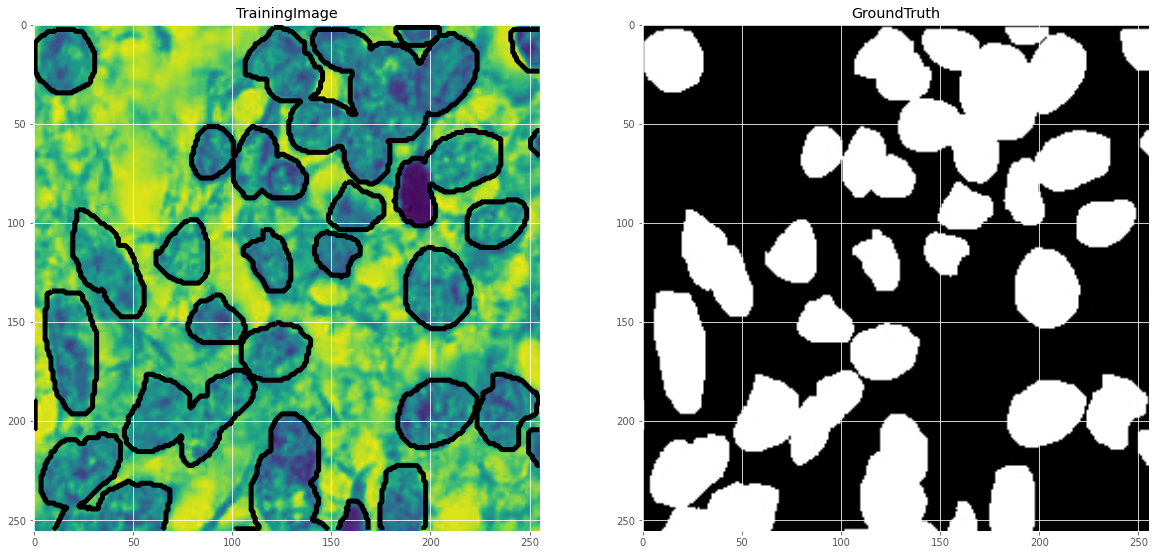

In [14]:
# Visualize any randome image along with the mask
ix = 5
#random.randint(0, len(X))
has_mask = Y[ix].max() > 0 # nuclie indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if  nucliea draw a boundary(contour) in the original image separating infected and non-infected areas
    ax1.contour(Y[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TrainingImage')

ax2.imshow(Y[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [17]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________

In [18]:
BATCH_SIZE= 32
STEPS_PER_EPOCH = np.ceil(len(ids_img)/BATCH_SIZE)
print ("steps per epoch: ", STEPS_PER_EPOCH)

steps per epoch:  2.0


In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-monuseg.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)

In [21]:
results = model.fit(X_train, y_train, batch_size=32, epochs=200, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))



Train on 230 samples, validate on 26 samples
Epoch 1/200
230/230 [==============================] - 11s 49ms/step - loss: 0.5716 - acc: 0.7828 - val_loss: 0.4190 - val_acc: 0.9148

Epoch 00001: val_loss improved from inf to 0.41896, saving model to model-tgs-monuseg.h5
Epoch 2/200
230/230 [==============================] - 1s 5ms/step - loss: 0.4481 - acc: 0.9206 - val_loss: 0.3405 - val_acc: 0.9294

Epoch 00002: val_loss improved from 0.41896 to 0.34048, saving model to model-tgs-monuseg.h5
Epoch 3/200
230/230 [==============================] - 1s 5ms/step - loss: 0.3853 - acc: 0.9388 - val_loss: 0.3167 - val_acc: 0.9276

Epoch 00003: val_loss improved from 0.34048 to 0.31669, saving model to model-tgs-monuseg.h5
Epoch 4/200
230/230 [==============================] - 1s 5ms/step - loss: 0.3543 - acc: 0.9396 - val_loss: 0.4329 - val_acc: 0.9027

Epoch 00004: val_loss did not improve from 0.31669
Epoch 5/200
230/230 [==============================] - 1s 5ms/step - loss: 0.3277 - acc: 

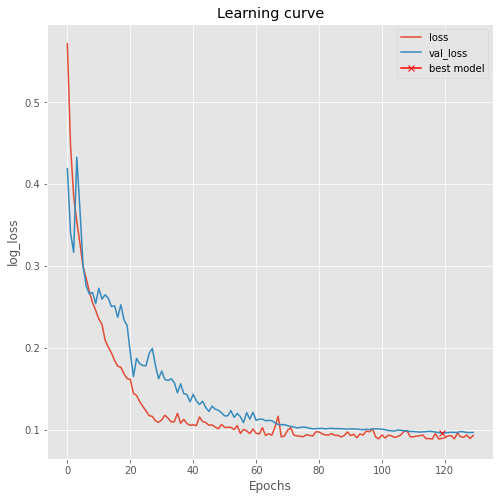

In [22]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [24]:
# Settin path to dataset
ids_img= next(os.walk(Npath_train_images))[2] # list of names all images in the given path
ids_mask= next(os.walk(Npath_train_groundtruth))[2]
print("No. of images = ", len(ids_img))
print("No. of images_GroundTruth = ", len(ids_mask))

No. of images =  64
No. of images_GroundTruth =  64


In [27]:
# Evaluate on validation set (this must be equals to the best log_loss)
score= model.evaluate(X_valid, y_valid, verbose=1)

26/26 [==============================] - 0s 2ms/step


In [28]:
print("Accuracy: ",score[0])
print("Loss: ",score[1])

Accuracy:  0.8794806003570557
Loss:  0.5286607146263123


working on test set

In [0]:
Npath_test_images= "yMonuSeg/Test/TissueImages/"
Npath_test_groundtruth= "yMonuSeg/Test/GroundTruths/"

In [30]:
Xs = np.zeros((256, 256,256,1), dtype=np.float32)
Ys = np.zeros((256, 256,256,1), dtype=np.float32)
print ("Shape of Xs is:",Xs.shape)
print ("Shape of ys is:", Ys.shape)

Shape of Xs is: (256, 256, 256, 1)
Shape of ys is: (256, 256, 256, 1)


In [31]:
ids_test= next (os.walk("yMonuSeg/Test/TissueImages"))[2]
print ("No. of images= ", len (ids_test))
print(ids_test)

No. of images=  14
['TCGA-69-7764-01A-01-TS1.jpg', 'TCGA-44-2665-01B-06-BS6.jpg', 'TCGA-2Z-A9J9-01A-01-TS1.jpg', 'TCGA-HC-7209-01A-01-TS1.jpg', 'TCGA-GL-6846-01A-01-BS1.jpg', 'TCGA-FG-A4MU-01B-01-TS1.jpg', 'TCGA-EJ-A46H-01A-03-TSC.jpg', 'TCGA-CU-A0YN-01A-02-BSB.jpg', 'TCGA-AO-A0J2-01A-01-BSA.jpg', 'TCGA-AC-A2FO-01A-01-TS1.jpg', 'TCGA-A6-6782-01A-01-BS1.jpg', 'TCGA-ZF-A9R5-01A-01-TS1.jpg', 'TCGA-IZ-8196-01A-01-BS1.jpg', 'TCGA-HT-8564-01Z-00-DX1.jpg']


In [32]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("yMonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_= id_[:-4]+"_bin_mask.jpg"
    mask = load_img("yMonuSeg/Test/GroundTruths/" + mask_id_, grayscale=True) 
    mask = img_to_array(mask)
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    # Save images
    Xs[n] = x_img/255.0
    Ys[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
x_test= Xs
y_test= Ys

In [34]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(x_test, verbose=1)

256/256 [==============================] - 0s 2ms/step


In [0]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [37]:
print("IOU: " , iou_coef(y_test, preds_test))
print("Dice: " , dice_coef(y_test, preds_test))

IOU:  Tensor("Mean:0", shape=(), dtype=float32)
Dice:  Tensor("Mean_1:0", shape=(), dtype=float32)


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
TN, FP, FN, TP = confusion_matrix(y_test.flatten().astype(int),
                             preds_test.round(0).flatten().astype(int)).ravel()

print ("Accuracy:", round((TP+TN)/(TP+FP+TN+FN), 4))

print ("\n",classification_report(y_test.round(0).flatten().astype(int), preds_test.round(0).flatten().astype(int)))

Accuracy: 0.5055

               precision    recall  f1-score   support

           0       0.99      0.51      0.67  16598751
           1       0.01      0.67      0.03    178465

    accuracy                           0.51  16777216
   macro avg       0.50      0.59      0.35  16777216
weighted avg       0.98      0.51      0.66  16777216



In [0]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    #ax[0].imshow(X[ix, ..., 0])
    ax[0].imshow(X[ix, ..., 0])

    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('GroundTruth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted superimposed on original');

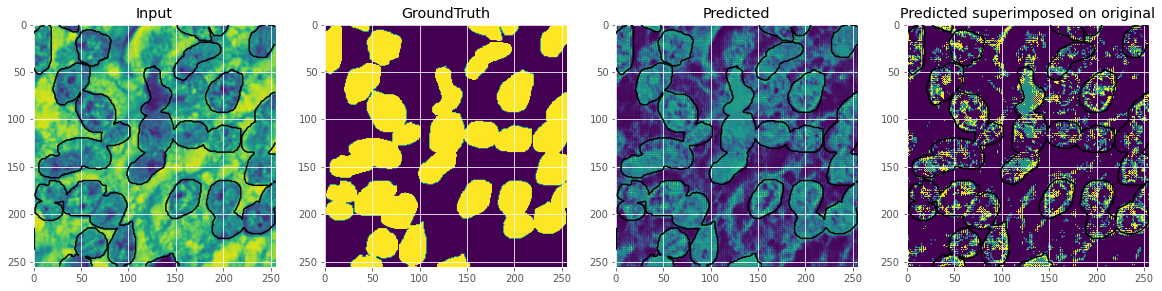

In [67]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=2)

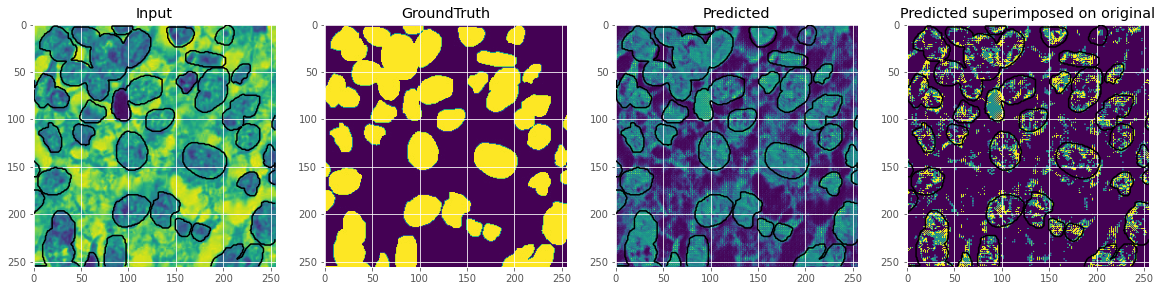

In [68]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1 )

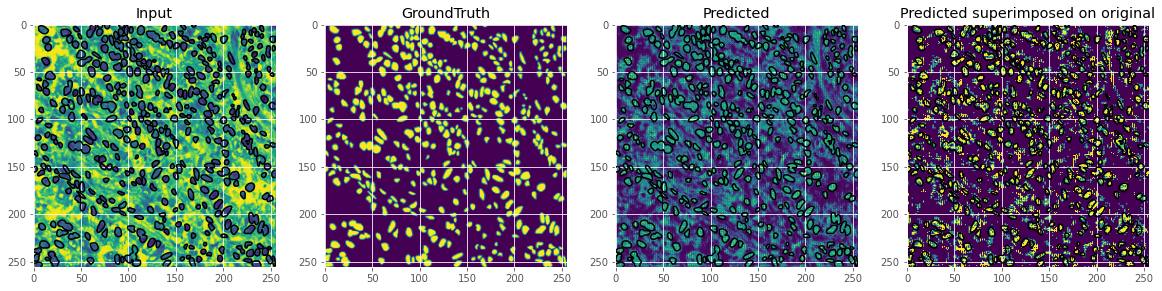

In [69]:
# Check if test data looks all right
plot_sample(x_test,y_test, preds_test, preds_test_t,ix=0 )